# Prediction of Pharmaceutical Sales 

### Objective:
- Merging both training and test data with the store data.
- Select and create main features and get them ready for training. 
- See which features has impact in this analysis from the selected features.

## Imports

In [116]:
#pip install tensorflow

In [117]:
import numpy as np
import pandas as pd
import mlflow
import warnings
import pickle
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import os, sys

In [118]:
from lightgbm import LGBMRegressor

In [119]:
# sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")

In [120]:
sys.path.append(os.path.abspath(os.path.join('../modules')))
from load_file import FileHandler
#from load_file import FileHandler
#from vis_seaborn import VisSeaborn
#from vis_plotly import VisPlotly

In [121]:
file_loader = FileHandler()


## Preprocessing

In [122]:
train_sales = file_loader.read_csv("../data/train.csv")

2022-05-28 12:26:13,435 — DfHelper — DEBUG — file read as csv


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Gezahegne\anaconda3\lib\logging\handlers.py", line 74, in emit
    self.doRollover()
  File "C:\Users\Gezahegne\anaconda3\lib\logging\handlers.py", line 428, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\Users\Gezahegne\anaconda3\lib\logging\handlers.py", line 115, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\Gezahegne\\10-Accademy\\Week-3\\pharma_sales_pridiction\\notebooks\\my_app_logs.log' -> 'C:\\Users\\Gezahegne\\10-Accademy\\Week-3\\pharma_sales_pridiction\\notebooks\\my_app_logs.log.2022-05-25'
Call stack:
  File "C:\Users\Gezahegne\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Gezahegne\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Gezahegne\anaconda3\l

In [123]:
data = train_sales.groupby("Date").agg({"Sales": "mean"})
data

,Sales
Date,
2013-01-01,84.40
2013-01-02,6178.52
2013-01-03,5660.17
2013-01-04,5923.14
2013-01-05,5299.05
...,...
2015-07-27,9371.97
2015-07-28,8066.85
2015-07-29,7545.02


In [124]:
scaler = StandardScaler()
scaled_array = scaler.fit_transform(data)
data['DataScaled'] = scaled_array

In [125]:
SIZE = len(data.DataScaled)
WINDOW_SIZE = 48
BATCH_SIZE = SIZE - WINDOW_SIZE * 2
EPOCHS = 200

In [126]:
DateTrain = data.index.values[0:BATCH_SIZE]
DateValid = data.index.values[BATCH_SIZE:]
XTrain = data.DataScaled.values[0:BATCH_SIZE].astype('float32')
XValid = data.DataScaled.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)


Shape of the training set date series:  (846, 1)
Shape of the validation set date series:  (96, 1)

Shape of the training set logarithm of sales series:  (846,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


In [127]:
tf.random.set_seed(1234)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([846, 1])

In [128]:
# create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float32, name=None)>

In [129]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True)

In [130]:
datasetEx = tf.data.Dataset.from_tensor_slices(tf.range(10))
datasetEx = datasetEx.window(5, shift=1, drop_remainder=True)
for window in datasetEx:
    print([elem.numpy() for elem in window])

[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]


In [131]:
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))

In [132]:
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

In [133]:
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [134]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [135]:
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

In [136]:
# Model training

In [137]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="huber_loss", optimizer='adam')

In [138]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, None, 8)           320       
                                                                 
 lstm_3 (LSTM)               (None, 4)                 208       
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [139]:
mlflow.set_experiment("LSTM")
mlflow.tensorflow.autolog()
history = model.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=1)

2022/05/28 12:28:02 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2022/05/28 12:28:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f3fd7a3fe7f749fd98f60809f292a2fb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/200
1/1 [==============================] - 144s 144s/step - loss: 0.4080 - val_loss: 0.3980
Epoch 2/200
1/1 [==============================] - 1s 1s/step - loss: 0.4072 - val_loss: 0.3966
Epoch 3/200
1/1 [==============================] - 1s 584ms/step - loss: 0.4064 - val_loss: 0.3952
Epoch 4/200
1/1 [==============================] - 0s 326ms/step - loss: 0.4056 - val_loss: 0.3938
Epoch 5/200
1/1 [==============================] - 1s 514ms/step - loss: 0.4048 - val_loss: 0.3925
Epoch 6/200
1/1 [==============================] - 1s 631ms/step - loss: 0.4041 - val_loss: 0.3911
Epoch 7/200
1/1 [==============================] - 0s 333ms/step - loss: 0.4034 - val_loss: 0.3897
Epoch 8/200
1/1 [==============================] - 0s 338ms/step - loss: 0.4027 - val_loss: 0.3884
Epoch 9/200
1/1 [==============================] - 0s 396ms/step - loss: 0.4020 - val_loss: 0.3870
Epoch 10/200
1/1 [==============================] - 0s 320ms/step - loss: 0.4013 - val_loss: 0.3857
Epoch 11/20

1/1 [==============================] - 0s 252ms/step - loss: 0.3822 - val_loss: 0.3417
Epoch 84/200
1/1 [==============================] - 0s 246ms/step - loss: 0.3819 - val_loss: 0.3413
Epoch 85/200
1/1 [==============================] - 0s 261ms/step - loss: 0.3816 - val_loss: 0.3410
Epoch 86/200
1/1 [==============================] - 0s 249ms/step - loss: 0.3814 - val_loss: 0.3406
Epoch 87/200
1/1 [==============================] - 0s 258ms/step - loss: 0.3811 - val_loss: 0.3402
Epoch 88/200
1/1 [==============================] - 0s 261ms/step - loss: 0.3808 - val_loss: 0.3398
Epoch 89/200
1/1 [==============================] - 0s 265ms/step - loss: 0.3805 - val_loss: 0.3394
Epoch 90/200
1/1 [==============================] - 0s 255ms/step - loss: 0.3803 - val_loss: 0.3390
Epoch 91/200
1/1 [==============================] - 0s 261ms/step - loss: 0.3800 - val_loss: 0.3386
Epoch 92/200
1/1 [==============================] - 0s 249ms/step - loss: 0.3797 - val_loss: 0.3381
Epoch 93/200


2022/05/28 12:31:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'PrefetchDataset' object has no attribute '_batch_size'


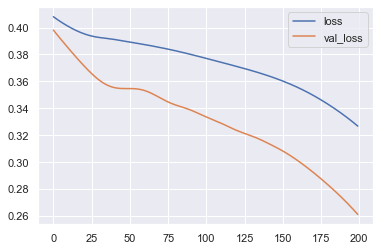

In [152]:
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [140]:
from time import gmtime, strftime


In [153]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True) 
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(SIZE).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [155]:
Forecast = model_forecast(model, train_sales.DataScaled.values[:, np.newaxis], WINDOW_SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1,1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1,1))

AttributeError: 'DataFrame' object has no attribute 'DataScaled'

In [141]:
time = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
model.save(f'../models/LSTM_sales_on {time}.pkl')

INFO:tensorflow:Assets written to: ../models/LSTM_sales_on 2022-05-28-09-31-40.pkl\assets


INFO:tensorflow:Assets written to: ../models/LSTM_sales_on 2022-05-28-09-31-40.pkl\assets


In [146]:
df = train_sales
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1485,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [147]:
# remove closed stores and those with no sales
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]

# sales for the store number 1 (StoreType C)
sales = df[df.Store == 1].loc[:, ['Date', 'Sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

# to datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [148]:
# from the prophet documentation every variables should have specific names
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales.head()

,ds,y
1014980,2013-01-02,5530
1013865,2013-01-03,4327
1012750,2013-01-04,4486
1011635,2013-01-05,4997
1009405,2013-01-07,7176


In [151]:
import Prophet
# create holidays dataframe
state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head()

ModuleNotFoundError: No module named 'Prophet'

In [142]:
params = {'n_estimators': 1742,
          'min_child_samples': 89,
          'n_jobs':-1,
          'learning_rate': 0.2723,
          'max_depth': -1,  
          'subsample': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 0.1,
          'reg_lambda': 1,
          'verbosity': -1}

In [143]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1485,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [144]:
#LightGBM Regressor
lgbm = LGBMRegressor(**params, random_state=42)

In [145]:
ID = test_df['Id']
test_df.drop('Id',inplace=True,axis=1)

train_df.sort_values(["Store","Date"], ignore_index=True, inplace=True)
test_df.sort_values(["Store","Date"], ignore_index=True, inplace=True)

for dataset in (train_df,test_df):
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    dataset['Day'] = dataset.Date.dt.day
    dataset['Month'] = dataset.Date.dt.month
    dataset['Year'] = dataset.Date.dt.year
    dataset['DayOfYear'] = dataset.Date.dt.dayofyear
    dataset['WeekOfYear'] = dataset.Date.dt.weekofyear
    dataset.set_index('Date', inplace=True)

NameError: name 'test_df' is not defined

In [ ]:
train_df = df_train[df_train['Open'] == 1]
train_df = df_train[df_train['Sales'] > 0.0]

In [ ]:
corr_matrix = train_df.corr()
corr_matrix["Sales"].sort_values(ascending=False)

In [ ]:
#Sort the values to use the last days as a validation set
temp = train_df.sort_values(["Year","Month","Day"], ignore_index=True).copy()

#The same time period as the test set
train = temp[:-47000].copy()       
vali = temp[-47000:].copy()

#Return to the same order as the original dataset
train.sort_values(["Store"], ignore_index=True, inplace=True)
vali.sort_values(["Store"], ignore_index=True, inplace=True)
train.sort_values(["Year","Month","Day"], ascending=False ,ignore_index=True, inplace=True)
vali.sort_values(["Year","Month","Day"], ascending=False ,ignore_index=True, inplace=True)

#Get the target
y_test = vali['Sales'].copy()
vali.drop('Sales',inplace=True,axis=1)

## Loss function

## LGBM Regressor

In [ ]:
model = file_loader.read_model("LGBMRegressor-sales-2021-08-01-19:57")
model


In [ ]:
feat_imp = pd.DataFrame({'Feature': feature_columns, 'Feature Importance': model.feature_importances_})
feat_imp = feat_imp.set_index('Feature')
feat_imp = feat_imp.sort_values(by=['Feature Importance'], ascending=False)
feat_imp

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Feature Importance", y=feat_imp.index, data=feat_imp)
plt.ylabel('Feature', fontsize=14)
plt.xlabel('Feature Importance', fontsize=14)
plt.show()


In [ ]:
y_preds = model.predict(train_features) 
prediction_df = train_features.copy()
prediction_df["y_true"] = train_sales
prediction_df["y_pred"] = y_preds 
prediction_df[["y_true", "y_pred"]].head() 

In [ ]:
daily_trend = prediction_df.groupby(['Day']).agg({'y_true': 'mean', 'y_pred': 'mean'})
plt.figure(figsize=(18, 6))
sns.lineplot(x=daily_trend.index, y=daily_trend["y_true"])
sns.lineplot(x=daily_trend.index, y=daily_trend["y_pred"])

## Random Forest Regressor

In [ ]:
model = file_loader.read_model("RandomForestRegressor-sales-2021-08-01-20:17")
model

In [ ]:
feat_imp = pd.DataFrame({'Feature': feature_columns, 'Feature Importance': model.feature_importances_})
feat_imp = feat_imp.set_index('Feature')
feat_imp = feat_imp.sort_values(by=['Feature Importance'], ascending=False)
feat_imp

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Feature Importance", y=feat_imp.index, data=feat_imp)
plt.ylabel('Feature', fontsize=14)
plt.xlabel('Feature Importance', fontsize=14)
plt.show()


In [ ]:
y_preds = model.predict(train_features)
prediction_df = train_features.copy()
prediction_df["y_true"] = train_sales
prediction_df["y_pred"] = y_preds
prediction_df[["y_true", "y_pred"]].head()


In [ ]:
daily_trend = prediction_df.groupby(['Day']).agg({'y_true': 'mean', 'y_pred': 'mean'})
plt.figure(figsize=(18, 6))
sns.lineplot(x=daily_trend.index, y=daily_trend["y_true"])
sns.lineplot(x=daily_trend.index, y=daily_trend["y_pred"])

## XGBOOST Regressor

In [ ]:
model = file_loader.read_model("XGBRegressor-sales-2021-08-01-21:03")
model

In [ ]:
feat_imp = pd.DataFrame({'Feature': feature_columns, 'Feature Importance': model.feature_importances_})
feat_imp = feat_imp.set_index('Feature')
feat_imp = feat_imp.sort_values(by=['Feature Importance'], ascending=False)
feat_imp

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Feature Importance", y=feat_imp.index, data=feat_imp)
plt.ylabel('Feature', fontsize=14)
plt.xlabel('Feature Importance', fontsize=14)
plt.show()

In [ ]:
y_preds = model.predict(train_features)
prediction_df = train_features.copy()
prediction_df["y_true"] = train_sales
prediction_df["y_pred"] = y_preds
prediction_df[["y_true", "y_pred"]].head()


In [ ]:
daily_trend = prediction_df.groupby(['Day']).agg({'y_true': 'mean', 'y_pred': 'mean'})
plt.figure(figsize=(18, 6))
sns.lineplot(x=daily_trend.index, y=daily_trend["y_true"])
sns.lineplot(x=daily_trend.index, y=daily_trend["y_pred"])

## Time Series Model

In [ ]:
model = tf.keras.models.load_model("../models/TimeSeriesModel-Customers-2021-08-01-12:43.h5")

In [ ]:
model.summary()

In [ ]:
Image("../img/TimeSeriesModel-Customers-2021-08-01-12:43.png")

In [ ]:
WINDOW_SIZE = 48
train_df = file_loader.read_csv("../data/train.csv")

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(len(series)).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
sales_data = train_df.groupby("Date").agg({"Sales": "mean"})[:100].copy()

In [ ]:
scaler = StandardScaler()
scaled_array = scaler.fit_transform(sales_data)
sales_data['DataScaled'] = scaled_array
BATCH_SIZE = len(sales_data) - (WINDOW_SIZE * 2)

In [ ]:
Forecast = model_forecast(model, sales_data.DataScaled.values[:, np.newaxis], WINDOW_SIZE)
Results = Forecast[BATCH_SIZE - WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1, 1))

In [ ]:
prediction_df = sales_data[BATCH_SIZE - WINDOW_SIZE:-1]
prediction_df["Forecast"] = Results1
prediction_df[["Forecast", "Sales"]]

In [ ]:
plt.figure(figsize=(30, 8))
plt.title("LSTM Model Forecast Future sales")
sns.lineplot(x=prediction_df.index, y=prediction_df["Forecast"])
sns.lineplot(x=prediction_df.index, y=prediction_df["Sales"])
plt.xticks(rotation=90)
plt.show()